# Homework 6: Part I

1. Go get data from kaggle.com and do a ***(Univariate) Bayesian Logistic Regression*** analysis

2. Adjust the code below to specify that the outcomes have a Bernoulli distribution and use a ***logit*** or ***probit link function*** (or $\Pr(z\leq 0)$ for latent $z$ ) to correctly paramterize the predicted values of the observed outcomes 

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

3. Choose ***prior*** that are sensible for your specification 

4. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Go get data from kaggle.com and do a ***Multivariate Bayesian Logistic Regression*** analysis


I used the Titanic data set from kaggle.com and will be predicting the survival chance of passengers. https://www.kaggle.com/competitions/titanic/data?select=train.csv

In [35]:
import pandas as pd
import pymc as pm
import numpy as np

# Load the data
data = pd.read_csv('titanic.csv').dropna()
X = data[['Age', 'Fare', 'Parch', 'Pclass']]
X /= X.max(axis=0)
X = X.to_numpy()
y = np.expand_dims(np.array(data['Survived']), 1)
p = 4

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    _y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma)
    prob = pm.Deterministic('p', pm.math.sigmoid(_y))
    _z = pm.Bernoulli('z', p=prob, observed=y)

with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma, y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 308 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

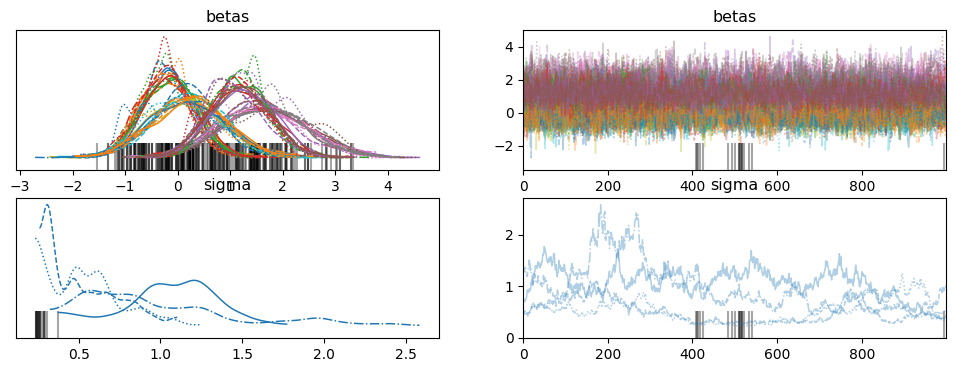

In [38]:
import arviz as az
az.plot_trace(idata, var_names=['betas', 'sigma'])

In [43]:
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.ones((p)), cov=3 * np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=0.5, sigma=0.5, lower=0) # half normal
    _y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma)
    prob = pm.Deterministic('p', pm.math.sigmoid(_y))
    _z = pm.Bernoulli('z', p=prob, observed=y)

with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma, y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

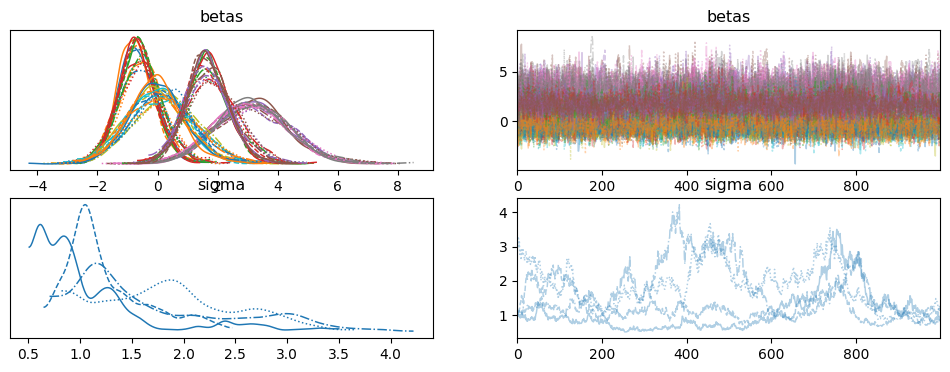

In [44]:
az.plot_trace(idata, var_names=['betas', 'sigma'])

# Homework 6: Part II<br>Regularized Loss Functions

***Machine Learning*** fits models by optimizing penalized ***loss functions***

Two classic regularizations are "ridge" and "lasso" regression, which respectively use $L_2$ and $L_1$ penalty functions

- Lasso: $$\sum_{i=1}^n \frac{1}{2}(y_i-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_2^2 $$
- Ridge: $$\sum_{i=1}^n \frac{1}{2}(y-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_1$$
    
Show that for $\sigma=1$ and ***hyperparameters*** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either ***normal*** or ***Laplace*** prior distributions have analagous forms to the above expressions

Now write down and understand the following: "Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nonetheless 'regularizations' of the likelihood through the prior."

We will show tha a normal prior distribution on $\beta$ is equivalent to lasso regression. The posterior distribution of $\beta$ is proportional to the likelihood times the prior distribution of $\beta$:
\begin{align*}
p(\beta | X) &\propto p(y | X, \beta) p(\beta) \\
&= \left( \prod_{i=0}^n \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{1}{2}(y_i-X_i\beta)^2 \right) \right) (2 \pi)^{-0.5}det(\Sigma)^{-\frac{1}{2}} \exp\left(-\frac{1}{2}(\beta)^T \Sigma^{-1} (\beta) \right) \\
&\propto \left( \prod_{i=0}^n \exp\left(-\frac{1}{2}(y_i-X_i\beta)^2 \right) \right) \exp\left(-\frac{1}{2} \beta^T \Sigma^{-1} \beta \right) \\
\end{align*}

We can now take the log of the posterior to get:
\begin{align*}
\log(p(\beta | X)) &\propto \sum_{i=0}^n \left(-\frac{1}{2}(y_i-X_i\beta)^2 \right) -\frac{1}{2} \beta^T \Sigma^{-1} \beta \\
&= \frac{-1}{2} \sum_{i=0}^n (y_i-X_i\beta)^2 -\frac{1}{2} \beta^T \Sigma^{-1} \beta \\
&\propto \frac{1}{2} ||y-X\beta||_2^2 + \frac{1}{2}  | \Sigma^{-1}| ||\beta||_2^2 \\
\end{align*}

Where $| \Sigma^{-1}|$ is equivalent to the factor $\lambda$ in original formulation of Lasso. 


Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nonetheless 'regularizations' of the likelihood through the prior.